In [66]:
import os
import numpy as np

data_path = '/home/nguyenquan/Desktop/Baitaplon_MachinLearning'

train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')

test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')



#read gzip
def get_mnist_data (images_path, labels_path, num_images, shuffle = False, _is=True, image_size= 28):

    #read data
    import gzip       # to decompress gz (zip) file

    # open file training to read training data
    f_images = gzip.open(images_path, 'r')

    # skip 16 first bytes because these are not data, only deader infor
    f_images.read(16)


    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)

        images = images[rand_id, :]
        labels = labels[rand_id,]

    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels


train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 784) (60000,)
(10000, 784) (10000,)


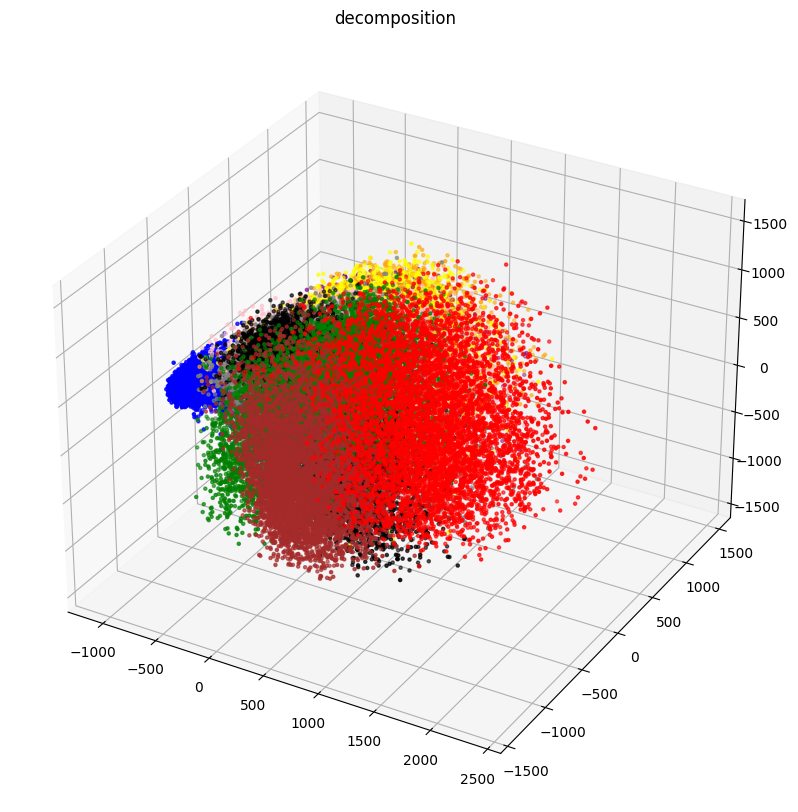

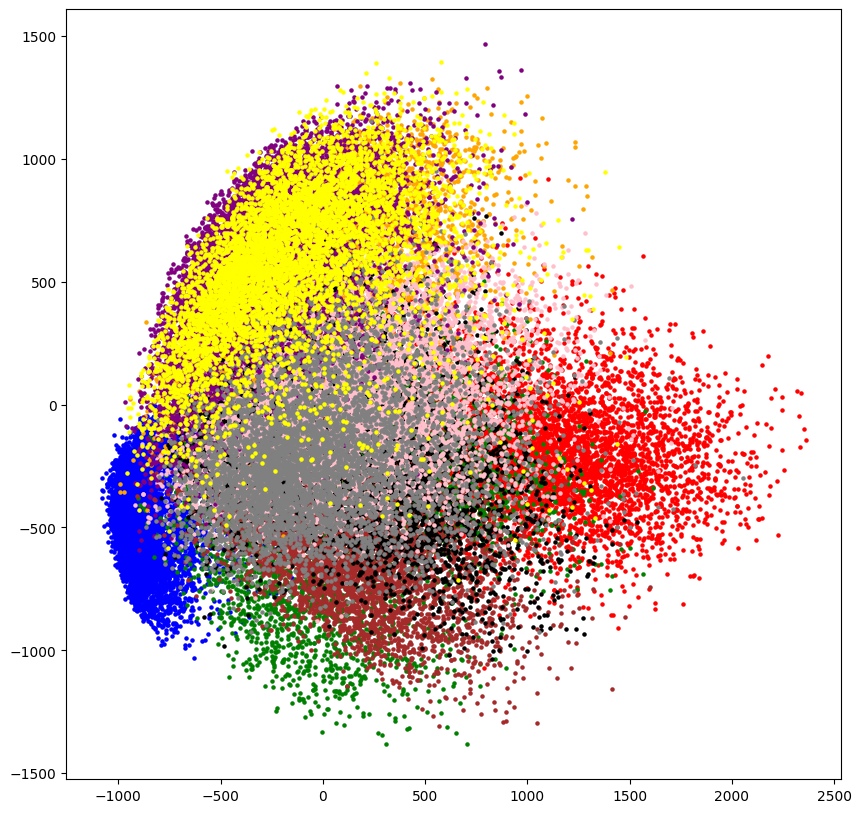

In [67]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca3D = PCA(n_components=3)

pca3D.fit(train_images)

pac_transform3D = pca3D.transform(train_images)


fig3 = plt.figure()
fig3.set_size_inches(10,10)
ax = plt.axes(projection='3d')
colors = ['red','blue','green','brown', 'orange', 'black', 'pink','purple','gray','yellow']

for label in range(10):
    ax.scatter(pac_transform3D[train_labels==label,0], pac_transform3D[train_labels==label,1], pac_transform3D[train_labels==label, 2], s= 5, c = colors[label])
    
ax.set_title('decomposition')
plt.show()


pca2D = PCA(n_components=2)
pca2D.fit(train_images)
pac_transform2D = pca2D.transform(train_images)

fig2 = plt.figure()
fig2.set_size_inches(10,10)
colors = ['red','blue','green','brown', 'orange', 'black', 'pink','purple','gray','yellow']
for label in range(10):
    plt.scatter(pac_transform2D[train_labels==label,0], pac_transform2D[train_labels==label,1],s=5, c = colors[label])
plt.show()


In [68]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_images, train_labels)


predictTest = clf.predict(test_images)
print(predictTest)

sum = 0
for i in predictTest:
    if (predictTest[i]-test_labels[i]==0):
        sum= sum +1

percentCorrect = sum/len(predictTest)
print(percentCorrect)



[7 2 1 ... 9 8 6]
0.8829


In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

accuracyMultinomial = accuracy_score(test_labels, predictTest)
confusionMatrixMultinomial= confusion_matrix(test_labels, predictTest)
precisionMultinomial = precision_score(test_labels, predictTest, average='macro')
recallMultinomial = recall_score(test_labels, predictTest, average='macro')

print("Accuracy:", accuracyMultinomial)
print("Confusion matrix:\n", confusionMatrixMultinomial)
print("Precision:", precisionMultinomial)
print("Recall:", recallMultinomial)



Accuracy: 0.8365
Confusion matrix:
 [[ 912    0    2    6    1    8   14    1   36    0]
 [   0 1061    5    9    0    2    6    0   51    1]
 [  15   11  858   24   10    3   33   11   66    1]
 [   4   11   34  851    1   21    7   14   40   27]
 [   2    2    6    0  732    0   25    1   38  176]
 [  23   11    6  107   18  590   17    6   78   36]
 [  17   13   17    1    7   25  860    0   18    0]
 [   1   21   11    5   19    0    1  861   40   69]
 [   6   26   13   54   14   27    8    9  777   40]
 [   6    7    3   10   66   10    0   17   27  863]]
Precision: 0.8433162997126132
Recall: 0.8334531845906966


65
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2 0 9 ... 2 1 5]


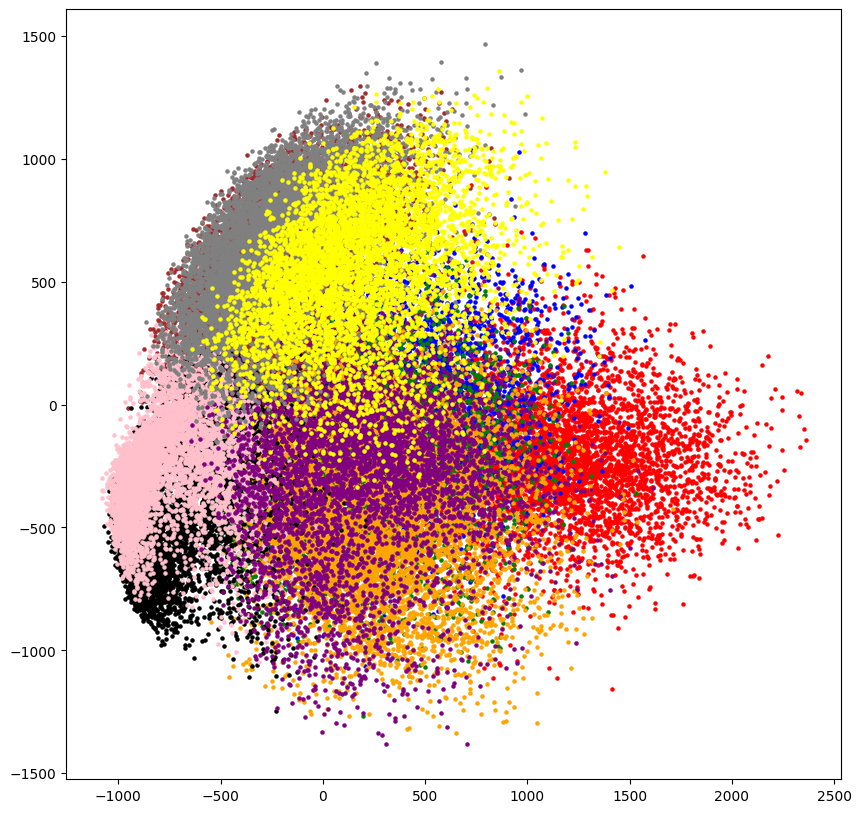

/home/nguyenquan/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


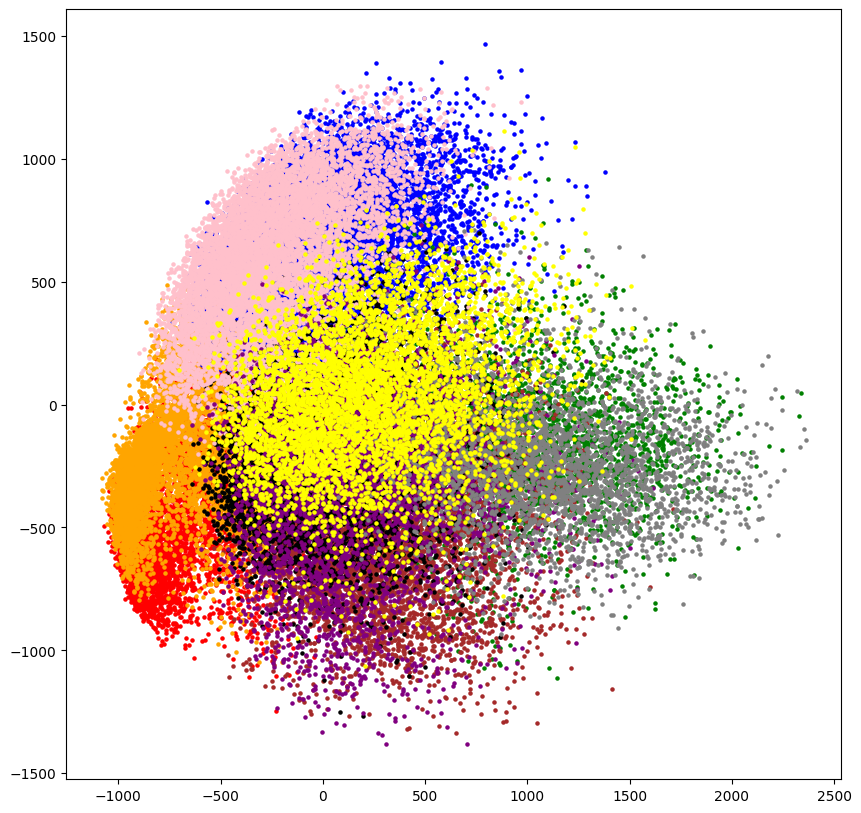

In [70]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------
#mean-K clustering
import math
from sklearn.cluster import KMeans
from scipy.spatial import distance as dist
def kmeans_creat_centers(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False),:]

def kmeans_assign_labels(X, centers):
    D = dist.cdist(X, centers)
    return np.argmin(D, axis=1)

def kmeans_update_centers(X, labels, k):
    centers = np.zeros((k, X.shape[1]))
    for i in range(k):
        Xk = X[labels == i, :]
        centers[i,:] = np.mean(Xk, axis=0)
    return centers

def has_converged(centers, new_centers):
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

def kmeans(X, k):
    centers = [kmeans_creat_centers(X,k)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], k)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it +=1
    return(centers, labels, it)


def kmeans_display(train_image, label_iamge, k):
    fig2 = plt.figure()
    fig2.set_size_inches(10,10)
    for label in range(k):
        plt.scatter(train_image[label_iamge == label,0],
                train_image[label_iamge == label,1],
                s=5, c = colors[label])
    plt.show()


train_array = np.array(train_images)
distortions = np.zeros((15))
K = 15

for i in range(K):
    (centers, labels, it) = kmeans(train_array, i+1)
    centers_array = np.array(centers[-1])
    labels_array = np.array(labels[-1])
    cdist_data =0
    for index in range(60000):
        cdist_data +=math.dist(train_array[index,:], centers_array[labels_array[index],:])    
    distortions[i] = cdist_data


plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, K+1, 1), distortions, 'go-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

(centers, label_image, it)= kmeans(train_images, 10)
print(it)
print(centers[-1])
print(label_image[-1])
kmeans_display(pac_transform2D, label_image[-1], 10)


kmeans_test = KMeans(n_clusters= 10, random_state=0)
kmeans_test = kmeans_test.fit(train_images)
kmeans_display(pac_transform2D, kmeans_test.labels_, 10)


In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1) 
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
print(train_labels[0])

model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3),padding="same", activation= 'relu', input_shape =(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(rate= 0.15),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu' , padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(rate=0.10),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu', use_bias=True, bias_initializer='zeros'),
    tf.keras.layers.Dense(units=10, activation='softmax', use_bias=True, bias_initializer='zeros') 
])
model.compile(optimizer= RMSprop(learning_rate = 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

 

history = model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=1000,
    callbacks=[callbacks],
    steps_per_epoch=60,
    epochs=15,
    verbose=2
)